In [ ]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.integrate import odeint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 24.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Burgers_data_np = np.load("/content/drive/MyDrive/Burgers_eq_data.pth.npy")

Burgers_data = torch.from_numpy(Burgers_data_np).type(torch.float32).to(device)

In [ ]:
# Generate training data

# Num of training samples
num_samples = 3000

np.random.seed(1)

# Spatial mesh
L_x = 1
dx = 0.005
N_x = int(L_x/dx + 1)
X = np.linspace(0,L_x,N_x)

# Temporal mesh
L_t = 1.0
dt = 0.005
N_t = int(L_t/dt + 1)
T = np.linspace(0,L_t,N_t)

k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)

# Datasets for training
phi = torch.zeros(size=(N_x*num_samples,N_x))
v = torch.zeros(size=(N_x*num_samples,N_x))
t = torch.zeros(size=(N_x*num_samples,1))

# Dataset used to store entire numerical solutions
Phi = np.zeros(shape=(num_samples,N_x,N_t))

# Data loop
for num in range(num_samples):


  # Random coefficients
  alpha = np.random.uniform(-1,1,6)
  phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5

  def burg_system(u,t,k):
    mu = 1
    nu = 0.01
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real


  #phi_i = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T

  phi_i = Burgers_data_np[num,:,:]

 # Phi[num,:,:] = phi_i

  time_indices = np.random.randint(0, T.size, N_x) #np.random.randint(0, 99, N_x) #np.random.randint(0, T.size, N_x)
  time_indices = np.arange(N_t)

  # Store data from Phi into suitable tensors for training.
  # These tensors are organized by (i) initial condition, (ii) later time for solution, (iii) later solution
  phi[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(phi_i[:,0])
  t[num*N_x:(num+1)*N_x,0] = torch.from_numpy(T[time_indices])
  v[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(np.transpose(phi_i[:,time_indices]))

  if num % 1000 == 0:
    print(num)

0
1000
2000


In [ ]:
File = "Burgers_geo_flow_data.pth"
np.save(File, Phi)

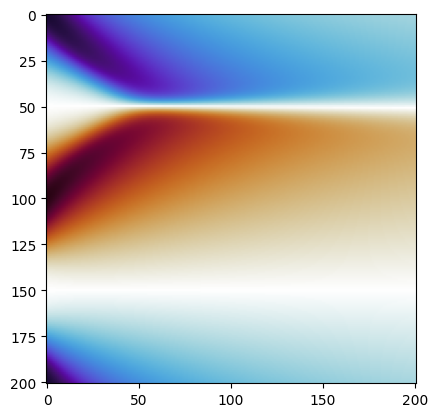

In [ ]:
plt.imshow(phi_i, cmap=cmr.fusion)

In [ ]:
# Initialize data with PyTorch for training

Phi = phi.type(torch.float32).to(device).requires_grad_()
V = v.type(torch.float32).to(device).requires_grad_()
times = t.type(torch.float32).to(device).requires_grad_()

In [ ]:
# Randomly sampled times
times_unif = np.random.uniform(0,1.0,size=(Phi.size(dim=0),1))
times_unif[0:num_samples] = 0
times_unif = torch.tensor(times_unif, requires_grad=True).type(torch.float32).to(device)

In [ ]:
w = 200
N_x = 201 # input width

intrinsic_dim = 3
extrinsic_dim = 2 * intrinsic_dim - 1

class parameterization_NN(nn.Module):
    def __init__(self):
        super(parameterization_NN, self).__init__()
        self.x_layer1 = nn.Linear(N_x,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True); self.x_layer3 = nn.Linear(w,w, bias=True)
        self.x_mean_1 = nn.Linear(w,w, bias=True); self.x_mean_2 = nn.Linear(w,intrinsic_dim, bias=True)
        self.x_std_1 = nn.Linear(w,w, bias=True); self.x_std_2 = nn.Linear(w,intrinsic_dim, bias=True)

    def forward(self, u):
        inputs = u
        x1_out = F.tanh(self.x_layer1(inputs)); x2_out = F.tanh(self.x_layer2(x1_out)); x3_out = F.tanh(self.x_layer3(x2_out))
        x_mean_1 = F.tanh(self.x_mean_1(x3_out)); x_mean_2 = self.x_mean_2(x_mean_1)
        x_std_1 = F.tanh(self.x_std_1(x3_out)); x_std_2 = self.x_std_2(x_std_1)
        return x_mean_2, x_std_2

In [ ]:
class psi_NN(nn.Module):
    def __init__(self):
        super(psi_NN, self).__init__()
        self.x_layer1 = nn.Linear(intrinsic_dim+1,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,extrinsic_dim, bias=True)

    def forward(self, uv, tau):
        inputs = torch.cat((uv, tau),1)
        x1_out = F.tanh(self.x_layer1(inputs))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
class decoder_NN(nn.Module):
    def __init__(self):
        super(decoder_NN, self).__init__()
        self.x_layer1 = nn.Linear(extrinsic_dim,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,N_x, bias=True)

    def forward(self, u):
        x1_out = F.tanh(self.x_layer1(u))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
# Create neural networks
parameterization = parameterization_NN().to(device) # local coordinates
psi = psi_NN().to(device) # from sphere manifold to learned manifold
decoder = decoder_NN().to(device) # decoder to PDE data

In [ ]:
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': psi.parameters()},
    {'params': decoder.parameters()}
], lr=2e-4)

In [ ]:
# Save newly-trained neural networks to current directory

parameterization.load_state_dict(torch.load("parameterization.pth"))
psi.load_state_dict(torch.load("psi.pth"))
decoder.load_state_dict(torch.load("decoder.pth"))

<All keys matched successfully>

In [ ]:
# Reparameterization trick
def get_reparameterization_sample(parameterization, U, intrinsic_dim, N):
  means_eval, stds_eval = parameterization(U)

  random_normal = torch.normal(0,1,size=(N,intrinsic_dim), requires_grad=True).to(device)

  uv_sample = means_eval  +   stds_eval * random_normal

  return uv_sample

In [ ]:
# Create function to get metric coefficients of the encoder neural network (not g)
def induced_metric_time_deriv_matrix_func(psi, uv, tau, intrinsic_dim, extrinsic_dim, N):

  psi_partial = torch.zeros(size=(N,extrinsic_dim,intrinsic_dim)).to(device)
  psi_rep = psi(uv, tau)
  for col in range(psi_partial.size(dim=1)):
    psi_partial[:,col,:] = torch.autograd.grad(psi_rep[:,col].sum(), uv, create_graph=True)[0]


  psi_partial_dt = torch.zeros(size=(N,extrinsic_dim,intrinsic_dim)).to(device)
  for col in range(psi_partial.size(dim=1)):
    psi_partial_dt[:,col,:] = torch.autograd.grad(psi_partial[:,col,:].sum(), tau, create_graph=True)[0]





  psi_metric = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)
  for i in range(intrinsic_dim):
    for j in range(i+1):
      psi_metric[:,i,j] = torch.sum( torch.squeeze(psi_partial[:,:,i]) * torch.squeeze(psi_partial_dt[:,:,j]), dim=1)
      psi_metric[:,j,i] = psi_metric[:,i,j]

  return psi_metric

In [ ]:
# Compute inverse of metric
def g_inv(G):
  G_inv = torch.linalg.pinv(G).to(device)
  return G_inv

In [ ]:
# Initialize metric of second manifold in the mapping
def g0_func(uv, tau, d, N):

  sin_uv = torch.sin(uv)
  metric_sphere = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)
  metric_sphere[:,0,0] = 1
  for i in range(1,intrinsic_dim):
    metric_sphere[:,i,i] = 1 * torch.prod(sin_uv[:,0:i]**2, dim=1)

  # Regularization with identity for nondegeneracy
  metric_sphere += 0.001 * torch.eye(d, device=metric_sphere.device).unsqueeze(0).expand(N, d, d)

  return metric_sphere

In [ ]:
# Decoded loss for PDE data
def loss_decoded_func(Phi_t, uv, tau, psi, decoder, parameterization, N):

  uv_sphere = map_to_sphere(uv)

  encoded_rep = psi(uv_sphere, tau)
  decoded_rep = decoder(encoded_rep)

  diff = decoded_rep - Phi_t
  loss = (1/torch.numel(diff)) * torch.norm(diff)**2

  return loss

In [ ]:
# KL divergence regularization with a Gaussian prior
def loss_kl_func(parameterization, Phi_0, N):

  means_eval, stds_eval = parameterization(Phi_0)
  epsilon = 1e-18

  kl_loss =  -torch.sum(1 + torch.log(stds_eval**2 + epsilon) - means_eval**2 - stds_eval**2, dim=1)

  return torch.mean(kl_loss)

In [ ]:
# This is the first manifold
def map_to_sphere(uv):

  # Use 2 for saved parameter
  uv_normalized = 2 * uv / torch.norm(uv, dim=1, keepdim=True)

  return uv_normalized



In [ ]:
# Harmonic map loss
def loss_harmonic_func(g0, psi, uv, tau, N):

  point_on_sphere = map_to_sphere(uv)

  g_inv_eval = g_inv(g0)

  psi_inner_prods = induced_metric_time_deriv_matrix_func(psi, point_on_sphere, tau, intrinsic_dim, extrinsic_dim, N)
  sym_tensor = psi_inner_prods + psi_inner_prods.transpose(-2, -1)
  integrand = torch.einsum('nij,nij->n', g_inv_eval, sym_tensor)

  functional_val = torch.mean(torch.abs(integrand))

  positive_constant = 10

  # Experiment with loss functions as desired but we found the last to be best
 # loss = torch.abs(functional_val)
 # loss = torch.mean(F.tanh(-0.1*functional_val))
  loss = torch.mean(torch.abs(functional_val - 0.5))

  return loss

In [ ]:
# Initialize the metric of the second manifold if desired, which we found helps
def loss_harmonic_map_normalization_condition(psi, uv, N):

  t0 = torch.zeros(size=(N,1)).to(device)

  psi_eval = psi(uv, t0)


  loss = torch.mean(torch.abs(torch.norm(psi_eval, dim=1) - 5))

  return loss

In [ ]:
index = 0
psi_eval_means = torch.zeros(size=(10000,extrinsic_dim)).to(device)
psi_eval_stds = torch.zeros(size=(10000,extrinsic_dim)).to(device)

In [ ]:
# Training algorithm

num_iter = 100

# Large batch size works well
N = 800




for num in range(num_iter):

  I = np.random.randint(0,int(num_samples*N_x),N)

  uv = get_reparameterization_sample(parameterization, Phi[I,:], intrinsic_dim, N)
  tau = times[I,:]
  tau_unif = times_unif[I,:]

  g0 = g0_func(uv, tau, intrinsic_dim, N)



  loss_kl = loss_kl_func(parameterization, Phi[I,:], N)
  loss_decoded = loss_decoded_func(V[I,:], uv, tau, psi, decoder, parameterization, N)
  loss_harmonic = loss_harmonic_func(g0, psi, uv, tau, N)
  loss_psi_sphere = loss_harmonic_map_normalization_condition(psi, uv, N)

  loss =   100 * loss_decoded  +   0.001 * loss_kl    +    loss_harmonic + loss_psi_sphere

  optimizer.zero_grad()
  loss.backward()

  #torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(psi.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(encoder.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    index += 1
    psi_eval = psi(uv, tau)
    psi_eval_means[index,:] = torch.mean(psi_eval.clone(), dim=0)
    psi_eval_stds[index,:] = torch.std(psi_eval.clone(), dim=0)
    print("Training loss:", '{:.4e}'.format(loss.data), \
          "Decoded:", '{:.4e}'.format(loss_decoded.data), \
         "Geo flow:", '{:.4e}'.format(loss_harmonic.data), \
          "KL:", '{:.4e}'.format(loss_kl.data))



In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "psi.pth"
torch.save(psi.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

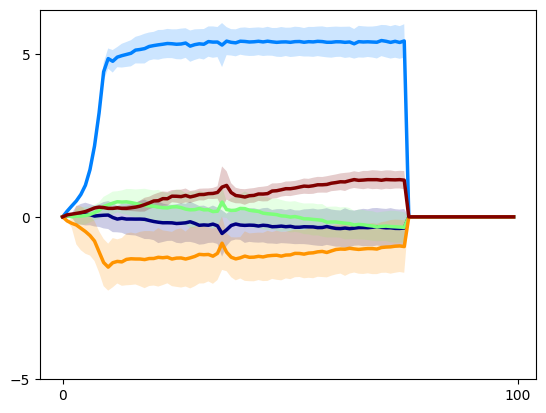

In [ ]:
# Riemannian metric means

colors = plt.cm.jet(np.linspace(0, 1, 5))

Num = 100
x = np.arange(Num)

for i in range(5):
    mean = psi_eval_means[0:Num, i].cpu().detach().numpy()
    std = psi_eval_stds[0:Num, i].cpu().detach().numpy()

    plt.plot(x, mean, linewidth=2.5, color=colors[i])
    plt.fill_between(
        x,
        mean + std,
        mean - std,
        facecolor=colors[i],
        alpha=0.2
    )

plt.xticks(ticks=[0,Num])
plt.yticks(ticks=[-5,0,5])

plt.savefig('metric.png', dpi=300)

In [ ]:
# Inference testing

np.random.seed(21)

phi_test = torch.zeros(size=(1,N_x,N_t)).to(device)
alpha = np.random.uniform(-1,1,6)
phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5  \
        #   + alpha[3]*np.sin(2*math.pi*X) + alpha[4]*(np.sin(2*math.pi*X))**3 + alpha[5]*(np.sin(2*math.pi*X))**5


phi_i_test = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T
phi_test[0,:,:] = torch.from_numpy(phi_i_test).to(device)


phi_test_noise = phi_test.clone()
noise = np.random.normal(0,1.5, size=(201))
noise[np.random.choice(201,100, replace=False)] = 0
phi_test_noise[0,:,0] = 1.0*phi_test[0,:,0]   +   torch.from_numpy(noise).to(device)

In [ ]:
decoded_2d = torch.zeros(size=(N_x,N_t))

for num in range(N_t):
  t_test = (num/(N_t))*torch.ones(size=(1,1)).to(device)
  t_index = int(t_test*100)

  means_eval, stds_eval = parameterization(phi_test_noise[0,:,0])
  random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
  uv_sample = means_eval

  uv_sphere_test = map_to_sphere(uv_sample.unsqueeze(0))

  encoded_rep = psi(uv_sphere_test.squeeze().unsqueeze(0), t_test)
  decoded_rep = decoder(encoded_rep)

  decoded_2d[:,num] = decoded_rep

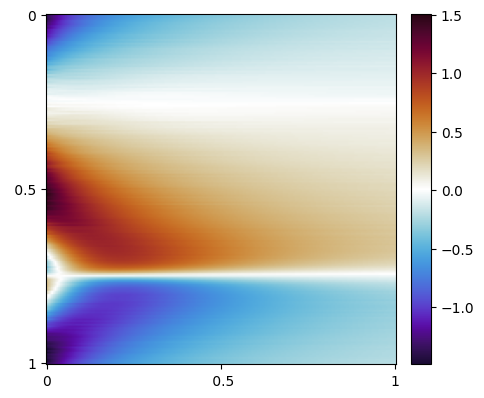

In [ ]:
heatmap2d(decoded_2d.cpu().detach().numpy())

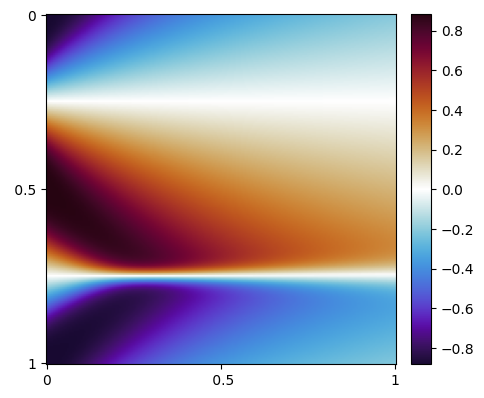

In [ ]:
heatmap2d(phi_test[0,:,:].cpu().detach().numpy())

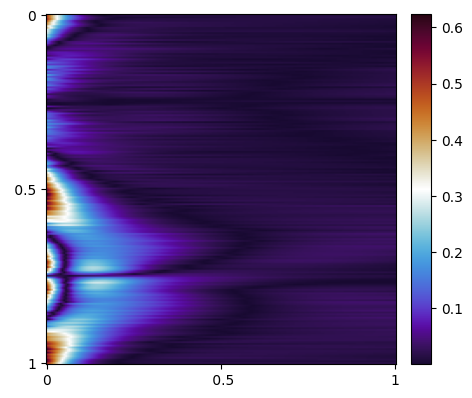

In [ ]:
heatmap2d( np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )

In [ ]:
print( np.sum(np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )    / np.sum(np.abs( phi_test[0,:,:].cpu().detach().numpy() ) )       )

0.11428486


In [ ]:
def heatmap2d(u):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

  im = ax.imshow(u[:,:], cmap=cmr.fusion_r)
                 #  vmin=-10, vmax=10)
  ax.set_xticks([0,100,200], ['0', ' 0.5', '1'])
  ax.set_yticks([0,100,200], ['0', ' 0.5', '1'])
  #ax.set_xticks([])
  #ax.set_yticks([])
  ax.grid(False)

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)

  cb_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
  cbar = fig.colorbar(im, cax=cb_ax)

  #cbar.ax.set_yticks((-10,-5,0,5,10))
  plt.savefig('burgers.png', dpi=700)
  plt.show()

In [ ]:
# Get errors
num_errors = 300
skip = 10 # Skip every P discretized points to help inference run faster; this is optional and has no impact on results


errors = np.zeros(shape=(num_errors,N_t))

np.random.seed(1)

for num_sample in range(num_errors):

  rand_i = np.random.randint(0,3000,1).squeeze()
  uu_test = torch.zeros(size=(1,201,201)).to(device)
  uu_test[0,:,:] = torch.from_numpy(Burgers_data_np[rand_i,:,:]).to(device)


  uu_test_noise = torch.zeros(size=(1,N_x,N_t)).to(device)
  uu_test_noise = uu_test.clone()
  noise = np.random.normal(0,3.0, size=(201))
  noise[11:201] = 0
 # noise[np.random.choice(201,100, replace=False)] = 0.0
  scaling = 2*np.pi*torch.range(0,200,1).to(device) / 201
  uu_test_noise[:,:,0] = 1.0*uu_test[:,:,0].clone()    + torch.from_numpy(noise).to(device)


  decoded_2d = torch.zeros(size=(N_x,N_t))

  for num in range(0, N_t, skip):
  #for num in range(N_t):
    t_test = T[num]*torch.ones(size=(1,1)).to(device)
    t_index = num

    means_eval, stds_eval = parameterization(uu_test_noise[:,:,0].unsqueeze(0))
    random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
    uv_sample = means_eval

    uv_sphere_test = map_to_sphere(uv_sample.squeeze().unsqueeze(0))

    encoded_rep = psi(uv_sphere_test.squeeze().unsqueeze(0), t_test)
    decoded_rep = decoder(encoded_rep)

    decoded_2d[:,num] = decoded_rep.clone()

    errors[num_sample,num] =  np.sum(np.abs(decoded_2d[:,num].cpu().detach().numpy().squeeze()  - uu_test[0,:,num].cpu().detach().numpy() ) ) \
                          / np.sum(np.abs(uu_test[0,:,num].cpu().detach().numpy()))

<ipython-input-78-2bb543be2ea0>:21: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  scaling = 2*np.pi*torch.range(0,200,1).to(device) / 201


In [ ]:
print(np.mean(errors[:,::skip]))
print(np.std(errors[:,::skip]))

0.41726830479585464
0.8811095797900919


In [ ]:
print(errors[:,::skip])

[[0.21044837 0.21550053 0.21689725 ... 0.05294111 0.05262053 0.0523165 ]
 [0.92762047 0.90876293 0.88793844 ... 0.67424154 0.68052864 0.68677419]
 [0.72123009 0.72656471 0.73306328 ... 0.70835406 0.70472151 0.70093483]
 ...
 [0.5410043  0.54416561 0.54578358 ... 0.13570487 0.13408799 0.13254119]
 [0.06449339 0.04814511 0.04868669 ... 0.02812619 0.02961244 0.03115162]
 [0.30046281 0.29636699 0.29595527 ... 0.08067473 0.07977351 0.07881328]]


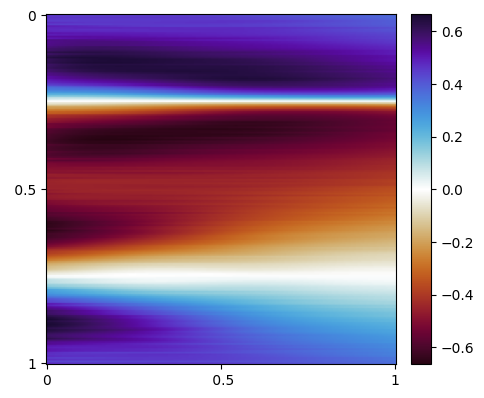

In [ ]:
heatmap2d(decoded_2d.cpu().detach().numpy())

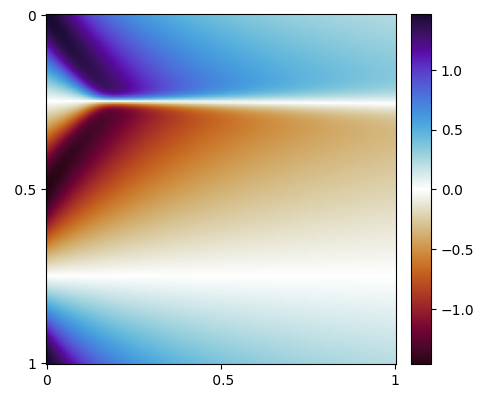

In [ ]:
heatmap2d(uu_test[0,:,:].cpu().detach().numpy())